# Feature Set Comparison

In [86]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

import shap

## Read in and Split Data

In [87]:
# read in data
data = pd.read_csv('../data/unemployment_data.csv')
data.head()

,initclaims_rate_regular,FIPS,State,County,Deaths,Years of Potential Life Lost Rate,% Fair or Poor Health,Average Number of Physically Unhealthy Days,Average Number of Mentally Unhealthy Days,% Low Birthweight,...,% Below Poverty,Median Household Income,% No College Degree,Unemployment Rate,% Not in Labor Force,% Jobs in Leisure and Hospitality,% Part-time,% Self-Employed,Presence of Water Violation (dummy Y/N),Other Primary Care Provider Ratio (:1)
0,26.0512,1001,Alabama,Autauga,791,8128.59119,20.882987,4.743889,4.654031,8.619529,...,12.1,58233,16.107796,2.7,40.454576,14.216260,39.604710,7.283256,0,2527
1,30.8648,1003,Alabama,Baldwin,2967,7354.12253,17.509134,4.224519,4.304056,8.345003,...,10.1,59871,21.044656,2.7,43.511495,20.823355,40.364194,12.669969,0,1787
2,24.5891,1005,Alabama,Barbour,472,10253.57340,29.591802,5.430279,5.185594,11.474559,...,27.1,35972,7.609664,3.8,58.630549,9.248695,54.696722,9.675502,0,1914
3,35.7501,1007,Alabama,Bibb,471,11977.53948,19.439724,4.591482,4.551699,10.308710,...,20.3,47918,6.451014,3.1,53.033744,4.345937,52.112959,7.547395,0,896
4,15.1614,1009,Alabama,Blount,1085,11335.07113,21.745293,4.860808,4.891455,7.604563,...,16.3,52902,8.625066,2.7,44.821051,10.342057,47.550659,7.815851,0,4449


In [88]:
X = data.drop(["FIPS", "initclaims_rate_regular", "State", "County"], axis=1)
y = pd.DataFrame(data["initclaims_rate_regular"])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [7]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train))
X_train.columns = X.columns

In [8]:
X_val = pd.DataFrame(scaler.transform(X_val))
X_val.columns = X.columns

In [9]:
X_test = pd.DataFrame(scaler.transform(X_test))
X_test.columns = X.columns

## MLP: XGBoost Most Important Features

In [10]:
X_train_x = X_train.filter(['% Without Health Insurance', 'Average Daily PM2.5','Unemployment Rate',
                '% Insufficient Sleep', '% American Indian & Alaska Native',
                '% Severe Housing Cost Burden', '% Excessive Drinking', 
                '% Self-Employed'])

X_val_x = X_val.filter(['% Without Health Insurance', 'Average Daily PM2.5','Unemployment Rate',
                '% Insufficient Sleep', '% American Indian & Alaska Native',
                '% Severe Housing Cost Burden', '% Excessive Drinking', 
                '% Self-Employed'])

X_test_x = X_test.filter(['% Without Health Insurance', 'Average Daily PM2.5','Unemployment Rate',
                '% Insufficient Sleep', '% American Indian & Alaska Native',
                '% Severe Housing Cost Burden', '% Excessive Drinking', 
                '% Self-Employed'])

In [11]:
"""
Loading custom dataset into Tensors
https://gist.github.com/conormm/5b26a08029b900520bcd6fcd1f5712a0
"""
class PrepareData(Dataset):
    def __init__(self, X, y):
        if not torch.is_tensor(X):
            self.X = torch.tensor(X.values).float()
        if not torch.is_tensor(y):
            self.y = torch.tensor(y.values).float()
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [12]:
train_data_x = PrepareData(X_train_x, y_train)
val_data_x = PrepareData(X_val_x, y_val)
test_data_x = PrepareData(X_test_x, y_test)

In [13]:
batch_size = 8

In [14]:
train_loader_x = DataLoader(train_data_x, 
                          batch_size)

valid_loader_x = DataLoader(val_data_x, 
                          batch_size)

test_loader_x = DataLoader(test_data_x, 
                         batch_size)

In [15]:
class MLP(nn.Module):
    def __init__(self, input_dim=8, output_dim=1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 6)
        self.fc2 = nn.Linear(6, 4)
        self.fc3 = nn.Linear(4, 2)
        self.fc4 = nn.Linear(2, output_dim)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        """
        Input
        -----
        x: tensor (batch size x important variable size)
        
        Output
        ------
        predicted values of Hosp rate
            tensor(batch size x 1)
        """
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        
        x = self.fc4(x)
        return x

In [18]:
mlp = MLP()
optimizer = optim.Adam(mlp.parameters())
criterion = nn.MSELoss()

In [19]:
"""
Training
Early Stopping based on best validation loss
"""
best_val_loss = np.inf 

avg_train_losses = []
avg_valid_losses = [] 

for epoch in range(25):
    train_losses = []
    valid_losses = []
    
    mlp.train()
    for data, outcome in train_loader_x:
        optimizer.zero_grad()
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    mlp.eval()
    for data, outcome in valid_loader_x:
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        valid_losses.append(loss.item())
    
    avg_train_losses.append(np.average(train_losses))
    avg_valid_losses.append(np.average(valid_losses))
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
    epoch+1, 
    avg_train_losses[-1],
    avg_valid_losses[-1]
    ))
    
    if avg_valid_losses[-1] < best_val_loss:
        best_val_loss = avg_valid_losses[-1]
        torch.save(mlp.state_dict(), 'mlp_x.model')

Epoch: 1 	Training Loss: 41.252606 	Validation Loss: 36.488989
Epoch: 2 	Training Loss: 40.018052 	Validation Loss: 33.817825
Epoch: 3 	Training Loss: 34.507751 	Validation Loss: 23.152106
Epoch: 4 	Training Loss: 23.978918 	Validation Loss: 16.767575
Epoch: 5 	Training Loss: 20.462052 	Validation Loss: 15.329338
Epoch: 6 	Training Loss: 19.544497 	Validation Loss: 14.705461
Epoch: 7 	Training Loss: 19.393289 	Validation Loss: 14.246913
Epoch: 8 	Training Loss: 18.779138 	Validation Loss: 14.001013
Epoch: 9 	Training Loss: 18.824729 	Validation Loss: 13.886441
Epoch: 10 	Training Loss: 19.086294 	Validation Loss: 13.742657
Epoch: 11 	Training Loss: 18.643643 	Validation Loss: 13.715873
Epoch: 12 	Training Loss: 18.581269 	Validation Loss: 13.660537
Epoch: 13 	Training Loss: 18.387167 	Validation Loss: 13.665487
Epoch: 14 	Training Loss: 18.913080 	Validation Loss: 13.600782
Epoch: 15 	Training Loss: 18.346850 	Validation Loss: 13.634776
Epoch: 16 	Training Loss: 18.374836 	Validation L

In [20]:
best_val_loss

13.524636909879487

In [21]:
mlp.load_state_dict(torch.load('mlp_x.model'))

In [22]:
# Test loss
test_loss = 0.0

mlp.eval()
for data, outcome in test_loader_x:
    output = mlp(data)
    loss = torch.sqrt(criterion(output, outcome))
    test_loss += loss.item()*data.size(0)

test_loss = test_loss/len(test_data_x)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 13.544304



### Explain output through SHAP

In [23]:
mlp = MLP()
mlp.load_state_dict(torch.load('mlp_x.model'))

In [24]:
x_x, _ = next(iter(train_loader_x))

In [25]:
#initialize js methods for visualization
shap.initjs()

# create an instance of the DeepSHAP which is called DeepExplainer
explainer_shap = shap.DeepExplainer(model=mlp,
                                 data=x_x)

shap_values = explainer_shap.shap_values(X=x_x,
                                      ranked_outputs=True)

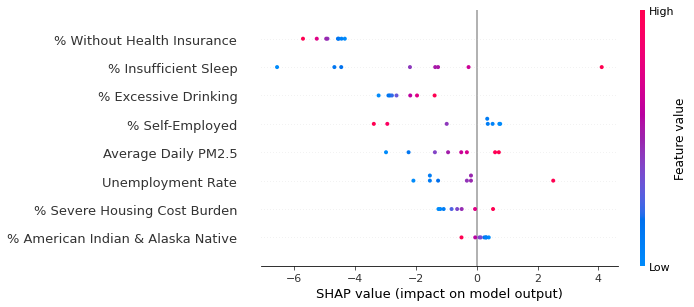

In [26]:
shap.summary_plot(shap_values, x_x, feature_names=X_train_x.columns)

## MLP: Original Features

In [74]:
X_train_o = X_train.filter(['% Below Poverty', 'Median Household Income', 
                            '% No College Degree', 'Unemployment Rate', '% Not in Labor Force',
                            '% Jobs in Leisure and Hospitality', '% Part-time',
                            '% Self-Employed'])

X_val_o = X_val.filter(['% Below Poverty', 'Median Household Income', 
                            '% No College Degree', 'Unemployment Rate', '% Not in Labor Force',
                            '% Jobs in Leisure and Hospitality', '% Part-time',
                            '% Self-Employed'])

X_test_o = X_test.filter(['% Below Poverty', 'Median Household Income', 
                            '% No College Degree', 'Unemployment Rate', '% Not in Labor Force',
                            '% Jobs in Leisure and Hospitality', '% Part-time',
                            '% Self-Employed'])

In [92]:
X_train_o = X_train_o.fillna(0)
X_val_o = X_val_o.fillna(0)
X_test_o = X_test_o.fillna(0)

In [93]:
train_data_o = PrepareData(X_train_o, y_train)
val_data_o = PrepareData(X_val_o, y_val)
test_data_o = PrepareData(X_test_o, y_test)

In [94]:
train_loader_o = DataLoader(train_data_o, 
                          batch_size)

valid_loader_o = DataLoader(val_data_o, 
                          batch_size)

test_loader_o = DataLoader(test_data_o, 
                         batch_size)

In [104]:
mlp = MLP()
optimizer = optim.Adam(mlp.parameters())
criterion = nn.MSELoss()

In [105]:
"""
Training
Early Stopping based on best validation loss
"""
best_val_loss = np.inf 

avg_train_losses = []
avg_valid_losses = [] 

for epoch in range(25):
    train_losses = []
    valid_losses = []
    
    mlp.train()
    for data, outcome in train_loader_o:
        optimizer.zero_grad()
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    mlp.eval()
    for data, outcome in valid_loader_o:
        output = mlp(data)
        loss = torch.sqrt(criterion(output, outcome))
        valid_losses.append(loss.item())
    
    avg_train_losses.append(np.average(train_losses))
    avg_valid_losses.append(np.average(valid_losses))
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
    epoch+1, 
    avg_train_losses[-1],
    avg_valid_losses[-1]
    ))
    
    if avg_valid_losses[-1] < best_val_loss:
        best_val_loss = avg_valid_losses[-1]
        torch.save(mlp.state_dict(), 'mlp_o.model')

Epoch: 1 	Training Loss: 41.242021 	Validation Loss: 36.614577
Epoch: 2 	Training Loss: 40.544034 	Validation Loss: 35.513008
Epoch: 3 	Training Loss: 38.245809 	Validation Loss: 31.427553
Epoch: 4 	Training Loss: 30.708800 	Validation Loss: 21.541990
Epoch: 5 	Training Loss: 24.798270 	Validation Loss: 18.466704
Epoch: 6 	Training Loss: 23.050127 	Validation Loss: 17.678798
Epoch: 7 	Training Loss: 23.250031 	Validation Loss: 17.075046
Epoch: 8 	Training Loss: 22.488726 	Validation Loss: 16.769270
Epoch: 9 	Training Loss: 22.167279 	Validation Loss: 16.530737
Epoch: 10 	Training Loss: 21.924289 	Validation Loss: 16.350493
Epoch: 11 	Training Loss: 21.934040 	Validation Loss: 16.168136
Epoch: 12 	Training Loss: 21.147707 	Validation Loss: 16.106976
Epoch: 13 	Training Loss: 21.139771 	Validation Loss: 16.097283
Epoch: 14 	Training Loss: 21.218553 	Validation Loss: 16.077227
Epoch: 15 	Training Loss: 21.208373 	Validation Loss: 15.943581
Epoch: 16 	Training Loss: 20.890779 	Validation L

In [106]:
best_val_loss

15.757777197607632

In [107]:
mlp.load_state_dict(torch.load('mlp_o.model'))

In [108]:
# Test loss
test_loss = 0.0

mlp.eval()
for data, outcome in test_loader_o:
    output = mlp(data)
    loss = torch.sqrt(criterion(output, outcome))
    test_loss += loss.item()*data.size(0)

test_loss = test_loss/len(test_data_o)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 16.115093



### Explain output through SHAP

In [111]:
mlp = MLP()
mlp.load_state_dict(torch.load('mlp_o.model'))

In [112]:
x_o, _ = next(iter(train_loader_o))

In [113]:
#initialize js methods for visualization
shap.initjs()

# create an instance of the DeepSHAP which is called DeepExplainer
explainer_shap = shap.DeepExplainer(model=mlp,
                                 data=x_o)

shap_values = explainer_shap.shap_values(X=x_o,
                                      ranked_outputs=True)

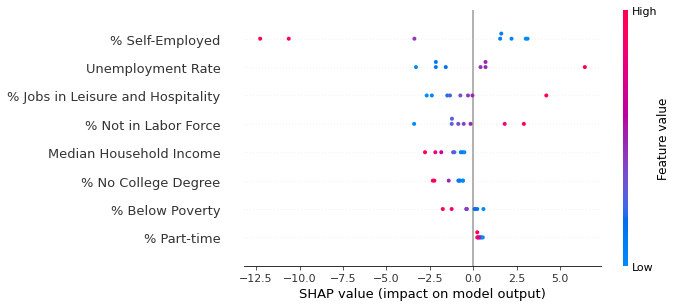

In [114]:
shap.summary_plot(shap_values, x_o, feature_names=X_train_o.columns)